In [2]:
# load data
# clean data
# features extraction
# model
# predict

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.toolbox import compare_freq

In [2]:
from Code.Tutorial.Dataset import load_scg

def load_(path):
    data = np.load(path)
    signals, labels = data[:, :1000], data[:, 1000:]
    return signals, labels


In [3]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)

    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([ m_12/m_21, mag_0/mag_1])

    return features

In [4]:
def fft_denoise(signal, threshold):
    """
    Applies FFT-based denoising to a signal.

    Parameters:
    signal (array-like): Input signal to be denoised.
    threshold (float): Threshold for filtering out noise.

    Returns:
    array-like: Denoised signal after applying FFT-based denoising.
    """

    num_samples = len(signal)  # Length of the input signal
    fhat = np.fft.fft(signal)  # Compute the FFT of the signal
    psd = fhat * np.conjugate(fhat) / num_samples  # Compute the power spectral density
    threshold = np.max(psd) * 0.1
    indices = psd > threshold  # Identify indices above the threshold for filtering
    fhat = indices * fhat  # Apply filtering to the FFT coefficients
    ffilt = np.fft.ifft(fhat)  # Compute the inverse FFT
    ffilt = ffilt.real  # Take the real part of the inverse FFT

    return ffilt

In [5]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

In [6]:

if __name__=='__main__':

    signals_n_0_train, labels_n_0_train = load_('../../Data/Normal/sim_5000_0.1_90_140_train_normal.npy')
    signals_n_0_test, labels_n_0_test = load_('../../Data/Normal/sim_3000_0.1_141_178_test_normal.npy')

    signals_n_0_train_ls = []
    labels_n_0_train_ls = []
    for cnt, signal in enumerate(signals_n_0_train):
        if max(signal) > 1:
            continue
        signals_n_0_train_ls.append(signal)
        labels_n_0_train_ls.append(labels_n_0_train[cnt])


    signals_n_0_test_ls = []
    labels_n_0_test_ls = []
    for cnt, signal in enumerate(signals_n_0_test):
        if max(signal) > 1:
            continue
        signals_n_0_test_ls.append(signal)
        labels_n_0_test_ls.append(labels_n_0_test[cnt])

    signals_n_0_train = np.array(signals_n_0_train_ls)
    signals_n_0_test = np.array(signals_n_0_test_ls)
    labels_n_0_train = np.array(labels_n_0_train_ls)
    labels_n_0_test = np.array(labels_n_0_test_ls)

    print(signals_n_0_train.shape, signals_n_0_test.shape)

    def extract(signals, labels, aplha):
        features = []
        idxs = []
        for cnt, signal in enumerate(signals):
            hr = labels[cnt, 2]
            fft_signal = fft_denoise(signal, 2)

            peaks, _ = find_peaks(fft_signal, height=np.max(fft_signal) * 0.12, distance=2000 // (hr * aplha))
            peaks = update_array(peaks, fft_signal / np.max(fft_signal))
            if len(peaks) % 2 != 0:
                peaks = np.delete(peaks, len(peaks) - 1)

            feature = get_features(fft_signal, peaks)
            features.append(feature)

            # if cnt % 61 == 0:
            #     plt.figure()
            #     plt.plot(fft_signal)
            #     plt.scatter(peaks, fft_signal[peaks])
            #     # plt.title(f'S:{labels[cnt, 4]} f:{feature[0]}')
            #     compare_freq(signal, fft_signal)
            #     plt.show()
            #
            # if cnt > 1000:
            #     break
        return np.array(features), np.array(idxs)

    features_train, idxs_train = extract(signals_n_0_train, labels_n_0_train, 1)
    features_test, idxs_test = extract(signals_n_0_test, labels_n_0_test, 1.2)


(4687, 1000) (2853, 1000)


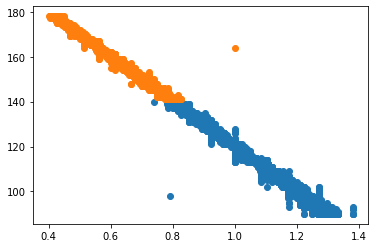

0.9195030624256212
Saved plot to ./pic/RemoveRR_S.jpg


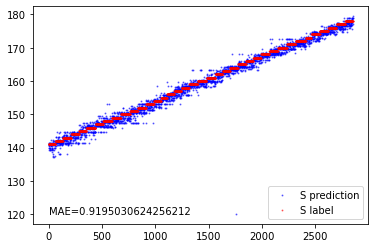

In [7]:
    plt.figure()
    plt.scatter(np.array(features_train)[:, 0], labels_n_0_train[:, 4])
    plt.scatter(np.array(features_test)[:, 0], labels_n_0_test[:, 4])
    plt.show()

    from sklearn.linear_model import LinearRegression as LR

    reg = LR().fit(np.array(features_train)[:, 0].reshape(-1, 1), labels_n_0_train[:, 4])
    yhat = reg.predict(np.array(features_test)[:, 0].reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_n_0_test[:, 4])))

    from Code.Tutorial.utils import plot_2vectors

    plot_2vectors( labels_n_0_test[:, 4], yhat, True, 'S', './pic/RemoveRR_S')


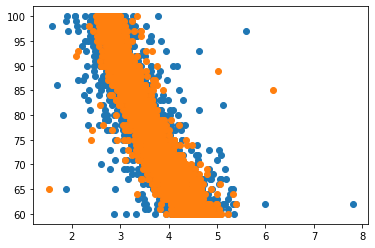

Saved plot to ./pic/RemoveRR_D.jpg


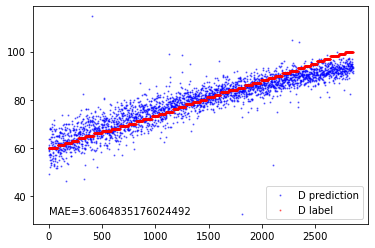

In [8]:
    plt.figure()
    plt.scatter(np.array(features_train)[:, 1], labels_n_0_train[:, 5])
    plt.scatter(np.array(features_test)[:, 1], labels_n_0_test[:, 5])
    plt.show()

    reg = LR().fit(np.array(features_train)[:, 1].reshape(-1, 1), labels_n_0_train[:, 5])
    yhat = reg.predict(np.array(features_test)[:, 1].reshape(-1, 1))
    plot_2vectors( labels_n_0_test[:, 5], yhat, True, 'D', './pic/RemoveRR_D')
